In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mcrt.test import TestAtmosphere

In [2]:
N_angles = 4
atm = TestAtmosphere(N_angles)
z = atm.z/1e5

In [3]:
M = atm.multiple_scatter_matrix(2)

In [4]:
M.shape

(400, 400)

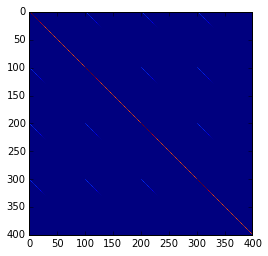

In [5]:
plt.imshow(M)

In [6]:
import pyauric
auric = pyauric.AURICManager('./inputs')
feat = ["O+{} 834 A (initial)".format(s) for s in ("hv", "e")]
src = auric.retrieve("dayglo.ver", features=feat)
auric_final = auric.retrieve("dayglo.ver", features=["834 A (final)"])
s0 = src[feat[0]] + src[feat[1]]
finals = []
for N_angles in xrange(2,6,2):
    atm = TestAtmosphere(N_angles)
    M = atm.multiple_scatter_matrix(2)
    s0_ang = np.hstack([s0]*N_angles)/N_angles
    sf_ang = np.dot(s0_ang,M)
    sf = np.sum(sf_ang.reshape(N_angles,len(z)),axis=0)
    finals.append(sf)

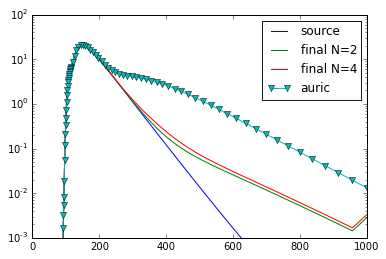

In [7]:
plt.plot(auric_final['ALT'],s0, label='source')
for i in xrange(len(finals)):
    plt.plot(z,finals[i],label='final N={}'.format(i*2+2))
plt.plot(auric_final['ALT'],auric_final['834 A (final)'], marker='v', label='auric')
# plt.plot(z,np.sum(np.dot(M,s0_ang).reshape(N_angles,len(z)),axis=0), label='wrong order')
plt.yscale('log')
plt.ylim(1e-3)
plt.legend()

Increasing the number of angles slowly but surely imporoves the match. This suggests that optical depths are too high inside the peak and that averaging more accurately when calculating depths in the first place might be very effective. There is also still a discontinuous drop-off at the highest altitude level. This could be related to the drop off to zero at the top of the atmosphere.

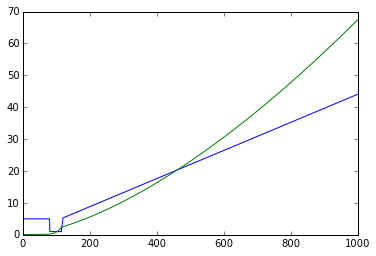

In [8]:
z_n = np.logspace(0,3,num=100)[::-1]
plt.plot(z[:-1],z[:-1]-z[1:])
plt.plot(z[:-1],z_n[:-1]-z_n[1:])

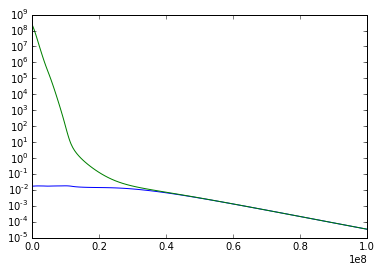

In [9]:
plt.plot(atm.z,np.sum(atm.tau_s[2]*atm.lineshape[2],axis=1))
plt.plot(atm.z,np.sum(atm.tau[2]*atm.lineshape[2],axis=1))
plt.yscale('log')

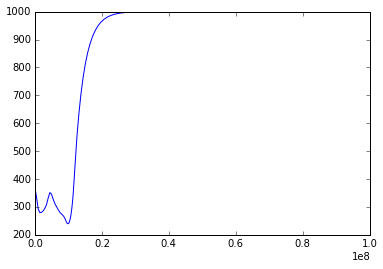

In [10]:
plt.plot(atm.z,atm.temperatures)

In [11]:
# Chandrasekhar 1st scattering result.
j_s = np.sum( (atm.albedo[2] / 4 * s0[:,None] * np.vstack([atm.extinction[0],np.zeros(23)]) * np.sum(atm.leg_weights * atm.mu) *  mu_0 /(mu_i + mu_0) * (1 - np.exp(-atm.tau[2]*(1/mu_0 + 1/mu_i)))*atm.lineshape[2] for mu_0 in atm.mu for mu_i in atm.mu), axis=1 ) 

/Users/georgegeddes/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from IPython.kernel.zmq import kernelapp as app
/Users/georgegeddes/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from IPython.kernel.zmq import kernelapp as app
/Users/georgegeddes/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from IPython.kernel.zmq import kernelapp as app


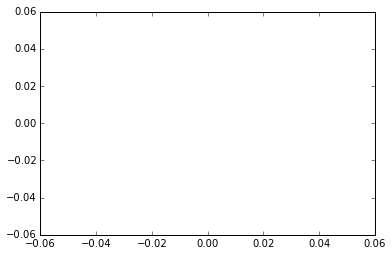

In [12]:
plt.plot(j_s)

In [13]:
j_s.shape

(100, 23)

In [14]:
atm.extinction[0].shape

(99, 23)

In [15]:
np.isnan(j_s).all()

True

In [16]:
M.shape

(400, 400)

In [17]:
help(np.linalg.svd)

Help on function svd in module numpy.linalg.linalg:

svd(a, full_matrices=1, compute_uv=1)
    Singular Value Decomposition.
    
    Factors the matrix `a` as ``u * np.diag(s) * v``, where `u` and `v`
    are unitary and `s` is a 1-d array of `a`'s singular values.
    
    Parameters
    ----------
    a : (..., M, N) array_like
        A real or complex matrix of shape (`M`, `N`) .
    full_matrices : bool, optional
        If True (default), `u` and `v` have the shapes (`M`, `M`) and
        (`N`, `N`), respectively.  Otherwise, the shapes are (`M`, `K`)
        and (`K`, `N`), respectively, where `K` = min(`M`, `N`).
    compute_uv : bool, optional
        Whether or not to compute `u` and `v` in addition to `s`.  True
        by default.
    
    Returns
    -------
    u : { (..., M, M), (..., M, K) } array
        Unitary matrices. The actual shape depends on the value of
        ``full_matrices``. Only returned when ``compute_uv`` is True.
    s : (..., K) array
        The si

In [18]:
u, s, v = np.linalg.svd(M)

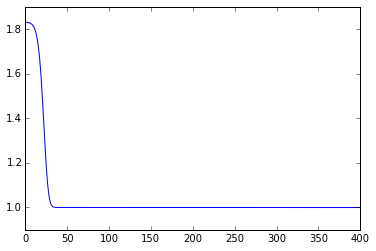

In [19]:
plt.plot(s[s!=0])

ValueError: x and y must have same first dimension

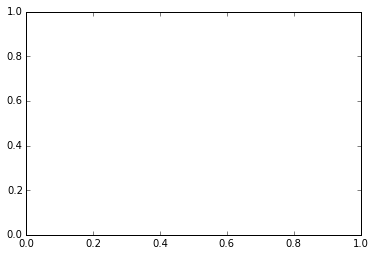

In [20]:
for i in xrange(0,3,1):
    plt.plot(np.hstack([z]*2), v[i])

In [ ]:
plt.pcolormesh(np.hstack([z,z+1000]),np.hstack([z,z+1000]),v)


Assuming $\mu>0$
$$
\begin{align}
I+dI &= I - \frac{\alpha dz}{\mu}I + j \frac{dz}{\mu}   \\
&= I - \frac{\alpha dz}{\mu}I + \frac{\alpha dz}{\mu}S \\
&\mathrm{Note:} -\alpha dz = d\tau\\ 
dI &= d\tau/\mu I - d\tau/\mu S\\
\mu\frac{dI}{d\tau} &= I - S
\end{align}$$

$$
\begin{align}
I+dI &= I - \frac{\alpha dz}{\mu}I + j \frac{dz}{\mu} + \alpha_s dz \int d\Omega' P(\mu,\mu')I(\mu,\tau)   \\
&= I - \frac{\alpha dz}{\mu}I + \frac{\alpha dz}{\mu}S + 2\pi\alpha_s dz \int d\mu' P(\mu,\mu')I(\mu,\tau) \\
&\mathrm{Note:} -\alpha dz = d\tau\\ 
dI &= d\tau/\mu I - d\tau/\mu S - 2\pi d\tau_s \int d\mu'P(\mu,\mu')I(\mu,\tau) \\
\mu\frac{dI}{d\tau} &= I - S - 2\pi \frac{d\tau_s}{d\tau} \int d\mu'P(\mu,\mu')I(\mu,\tau)\\
&= I - S - 2\pi \varpi(\tau) \int d\mu'P(\mu,\mu')I(\mu,\tau)
\end{align}$$

Now, make the Feautrier approximation: $u = \frac{1}{2}\left[I(\mu) + I(-\mu)\right], v=\frac{1}{2}\left[I(\mu)-I(-\mu)\right]$ (assume $\mu>0$). Take the derivative of $u$:


\begin{align} 
\frac{du}{d\tau} &=\frac{1}{2}\left[ \frac{dI(\mu)}{d\tau} + \frac{dI(-\mu)}{d\tau} \right]\\
&=\frac{1}{2}\left[  \frac{1}{\mu}\left(I(\mu) - S - 2\pi \varpi(\tau) \int d\mu'P(\mu,\mu')I(\mu,\tau)\right) - \frac{1}{\mu}\left(I(-\mu) - S - 2\pi \varpi(\tau) \int d\mu'P(-\mu,\mu')I(-\mu,\tau)\right) \right]\\
&= \frac{v}{\mu} + \frac{2\pi\varpi(\tau)}{\mu}\int d\mu'P(-\mu,\mu')v(\mu,\tau)
\end{align}

and of $v$:

\begin{align} 
\frac{dv}{d\tau} &=\frac{1}{2}\left[  \frac{dI(\mu)}{d\tau} - \frac{dI(-\mu)}{d\tau}\right]\\
&=\frac{1}{2}\left[  \frac{1}{\mu}\left(I(\mu) - S - 2\pi \varpi(\tau) \int d\mu'P(\mu,\mu')I(\mu,\tau)\right) + \frac{1}{\mu}\left(I(-\mu) - S - 2\pi \varpi(\tau) \int d\mu'P(-\mu,\mu')I(-\mu,\tau)\right)\right]\\
&= \frac{u - S}{\mu} - \frac{2\pi\varpi(\tau)}{\mu}\int d\mu'P(-\mu,\mu')u(\mu,\tau)
\end{align}

This leads us to the second order equation for $u$:

\begin{align}
\mu^2 \frac{d^2u}{d\tau^2} &= u - S + 2\pi\varpi(\tau)\int d\mu'P(\mu',\mu) (v-u) 
\end{align}

The presence of scattering prevents us from expressing an equation for $u$ separately from $v$.

For isotropic scattering, $P(\mu',\mu) = \frac{1}{4\pi}$, which simplifies the above to:

$$\mu^2 \frac{d^2u}{d\tau^2} = \left(1-\varpi(\tau)\right)u + \varpi(\tau)v -S
$$